# **Titanic Survival Classification**

### 1. Setup & Data Loading

In [2]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
df = pd.read_csv('titanic.csv')

In [4]:
# Dataset preview
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Initial Data Exploration

In [5]:
# Check dataset shape
print(f"Dataset Shape: {df.shape}")

# Check data types and missing values
print("\nDataset Information:")
df.info()

# Summary statistics
print("\nSummary Statistics:")
df.describe()

Dataset Shape: (891, 12)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Summary Statistics:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Check missing values
print("\nMissing Values per Column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values per Column:
Age         177
Cabin       687
Embarked      2
dtype: int64


### 3. Data Cleaning & Preprocessing

With our understanding of the dataset, we now address data quality issues to prepare for analysis.

- **Handling missing values**: 
  - Age: Filling with median (a robust measure for skewed distributions)
  - Cabin: Creating a binary feature (Has_Cabin) since the exact cabin may be less important than whether one was assigned
  - Embarked: Filling with the most common port

- **Feature transformation**:
  - Converting categorical variables (Sex, Embarked) to numeric values
  - Removing columns that aren't useful for prediction (PassengerId, Name, Ticket)
  - Creating a clean dataset for further analysis

In [7]:
# Create a copy of the dataframe to work with
clean_df = df.copy()

# Age - fill missing values with median
clean_df['Age'].fillna(clean_df['Age'].median(), inplace=True)

# Cabin - create a binary feature for whether the cabin is known
clean_df['Has_Cabin'] = clean_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# Embarked - fill missing values with the most common port
most_common_port = clean_df['Embarked'].mode()[0]
clean_df['Embarked'].fillna(most_common_port, inplace=True)

# Drop columns that are not useful for modeling
# PassengerId, Name, Ticket, Cabin (since we created Has_Cabin)
clean_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Convert categorical variables to numeric
clean_df['Sex'] = clean_df['Sex'].map({'male': 0, 'female': 1})
clean_df['Embarked'] = clean_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Check the cleaned dataset
print("\nCleaned Dataset:")
clean_df.head()


Cleaned Dataset:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin
0,0,3,0,22.0,1,0,7.2500,0,0
1,1,1,1,38.0,1,0,71.2833,1,1
2,1,3,1,26.0,0,0,7.9250,0,0
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,0


### 4. Exploratory Data Analysis (EDA)

Now that we have clean data, we can explore relationships and patterns within it. This visual exploration helps us:
- Understand survival patterns across different passenger characteristics
- Identify which factors might be most important for survival prediction
- Generate hypotheses that can inform our feature engineering and modeling

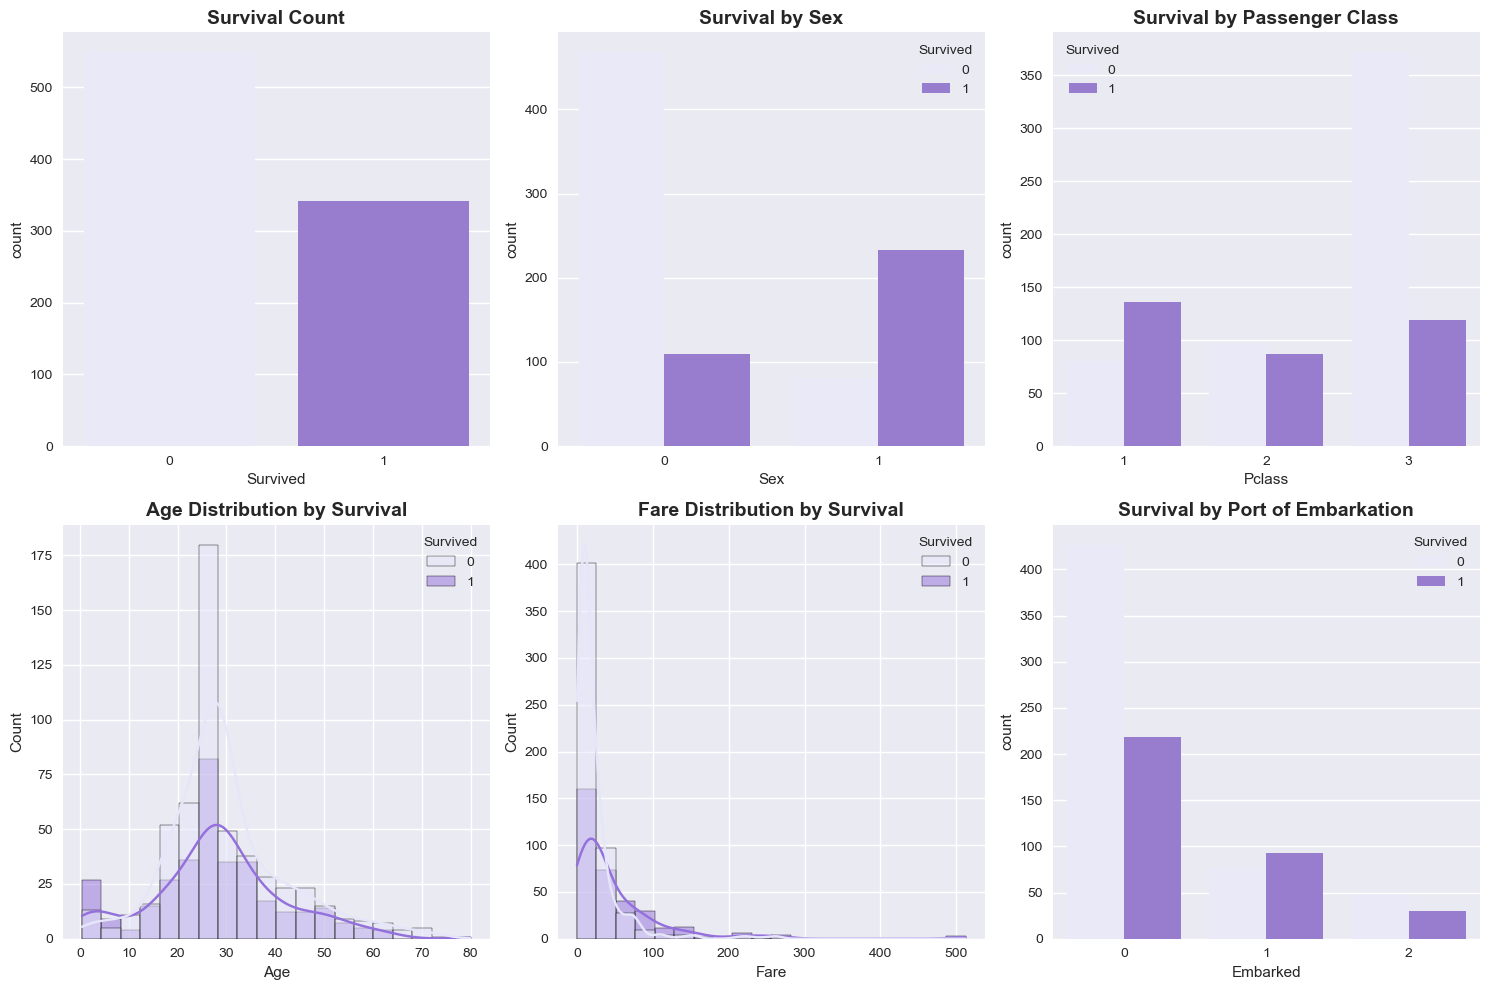

In [8]:
# Set purple theme colors
purple_palette = ['#E6E6FA', '#9370DB']
plt.style.use('seaborn-v0_8')  

plt.figure(figsize=(15, 10))

# Survival rate overall
plt.subplot(2, 3, 1)
sns.countplot(x='Survived', data=clean_df, palette=purple_palette)
plt.title('Survival Count', fontsize=14, fontweight='bold')

# Survival by Sex
plt.subplot(2, 3, 2)
sns.countplot(x='Sex', hue='Survived', data=clean_df, palette=purple_palette)
plt.title('Survival by Sex', fontsize=14, fontweight='bold')

# Survival by Passenger Class
plt.subplot(2, 3, 3)
sns.countplot(x='Pclass', hue='Survived', data=clean_df, palette=purple_palette)
plt.title('Survival by Passenger Class', fontsize=14, fontweight='bold')

# Age distribution
plt.subplot(2, 3, 4)
sns.histplot(data=clean_df, x='Age', hue='Survived', bins=20, kde=True, palette=purple_palette)
plt.title('Age Distribution by Survival', fontsize=14, fontweight='bold')

# Fare distribution
plt.subplot(2, 3, 5)
sns.histplot(data=clean_df, x='Fare', hue='Survived', bins=20, kde=True, palette=purple_palette)
plt.title('Fare Distribution by Survival', fontsize=14, fontweight='bold')

# Survival by Embarked
plt.subplot(2, 3, 6)
sns.countplot(x='Embarked', hue='Survived', data=clean_df, palette=purple_palette)
plt.title('Survival by Port of Embarkation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

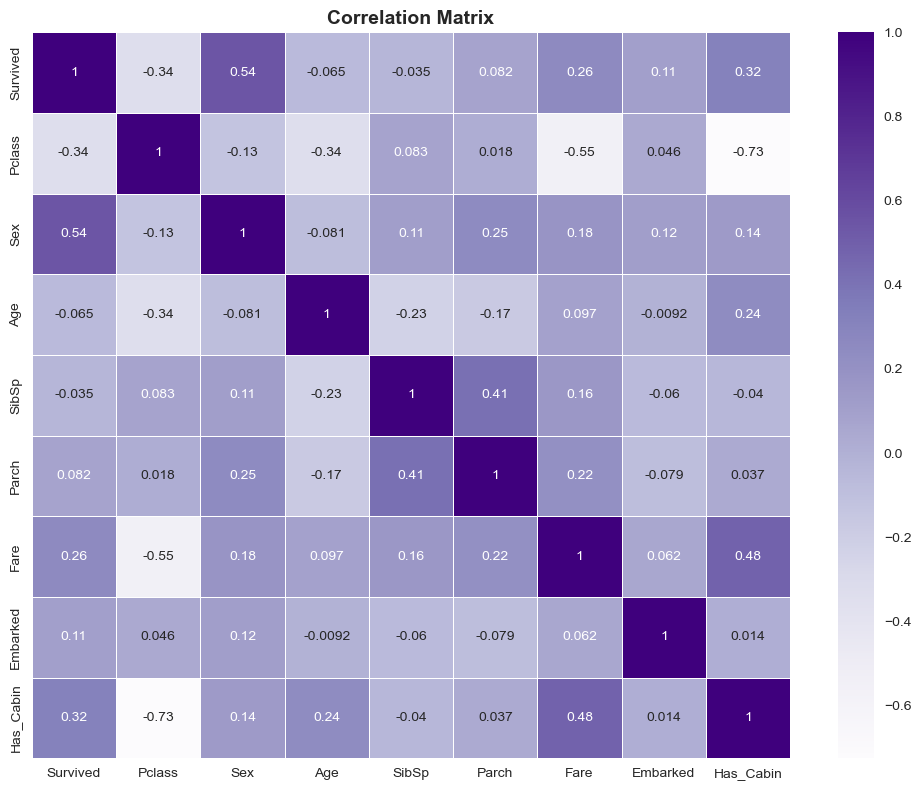

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = clean_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5. Feature Engineering

Based on our EDA insights, we can create new features that might improve model performance. 

- Create a **FamilySize** feature by combining siblings/spouses (SibSp) and parents/children (Parch)
- Generate an **IsAlone** indicator to identify solo travelers
- Group continuous variables (Age, Fare) into meaningful categories to capture non-linear relationships


In [11]:
# Create a new feature for family size
clean_df['FamilySize'] = clean_df['SibSp'] + clean_df['Parch'] + 1  # +1 for the passenger themselves

# Create a feature for if the passenger is alone
clean_df['IsAlone'] = (clean_df['FamilySize'] == 1).astype(int)

# Create age groups
clean_df['AgeGroup'] = pd.cut(clean_df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])

# Create fare groups
clean_df['FareGroup'] = pd.qcut(clean_df['Fare'], 4, labels=[0, 1, 2, 3])

# Check the dataset with new features
print("\nDataset with Engineered Features:")
clean_df.head()


Dataset with Engineered Features:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,AgeGroup,FareGroup
0,0,3,0,22.0,1,0,7.2500,0,0,2,0,2,0
1,1,1,1,38.0,1,0,71.2833,1,1,2,0,3,3
2,1,3,1,26.0,0,0,7.9250,0,0,1,1,2,1
3,1,1,1,35.0,1,0,53.1000,0,1,2,0,2,3
4,0,3,0,35.0,0,0,8.0500,0,0,1,1,2,1
